In [1]:
from NN.model_for_mnist import *
import numpy as np
from sklearn.model_selection import train_test_split
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device = torch.device("cpu")

In [2]:
from get import load_datasets, display_dataset

X_labeled, y_labeled, X_unlabeled, X_val = load_datasets(888)

{0: '00_toy_dataset', 1: '01_mnist_cc', 2: '02_mnist_constant_image', 3: '03_mnist_constant_image_random_row', 4: '04_mnist_uniform_color_random_row', 5: '05_mnist_uniform_color_low_mix_rate', 6: '06_mnist_sum', 7: '07_mnist_sum_bis', 8: '08_mnist_sum_noise_level', 12: '12_mnist_mysterious', 13: '13_mnist_mysterious', 23: '23_mnist_embed', 456: '456_mnist_embed', 888: '888_vehicle_animal', 998: '998_zip_humans', 999: '999_humans'}


In [3]:
print("Labeled ds shape: ", X_labeled.shape)
print("Unlabeled ds shape: ", X_unlabeled.shape)
print("Validation ds shape: ", X_val.shape)
print("Labels shape: ", y_labeled.shape)
print("Labeled ds labels: ", np.unique(y_labeled))

Labeled ds shape:  torch.Size([10000, 3, 32, 64])
Unlabeled ds shape:  torch.Size([20000, 3, 32, 64])
Validation ds shape:  torch.Size([20000, 3, 32, 64])
Labels shape:  torch.Size([10000])
Labeled ds labels:  [0. 1.]


In [4]:
# CUt 10000, 3, 32, 64 shaped images to 20000, 3, 32, 32
X_labeled_left = X_labeled[:, :, :, :32]
X_labeled_right = X_labeled[:, :, :, 32:]
y_labeled_left = y_labeled
y_labeled_right = y_labeled

X_unlabeled_left = X_unlabeled[:, :, :, :32]
X_unlabeled_right = X_unlabeled[:, :, :, 32:]

X_val_left = X_val[:, :, :, :32]
X_val_right = X_val[:, :, :, 32:]

In [5]:
# Concatenate left and right images
X_labeled_both = np.concatenate((X_labeled_left, X_labeled_right), axis=0)
y_labeled_both = np.concatenate((y_labeled_left, y_labeled_right), axis=0)
X_unlabeled_both = np.concatenate((X_unlabeled_left, X_unlabeled_right), axis=0)
X_val_both = np.concatenate((X_val_left, X_val_right), axis=0)

X_all_both = np.concatenate((X_labeled_both, X_unlabeled_both, X_val_both), axis=0)

In [6]:
# Print shapes
print("Labeled ds shape: ", X_labeled_both.shape)
print("Unlabeled ds shape: ", X_unlabeled_both.shape)
print("Validation ds shape: ", X_val_both.shape)
print("Labels shape: ", y_labeled_both.shape)
print("Labeled ds labels: ", np.unique(y_labeled_both))
print("All ds shape: ", X_all_both.shape)

Labeled ds shape:  (20000, 3, 32, 32)
Unlabeled ds shape:  (40000, 3, 32, 32)
Validation ds shape:  (40000, 3, 32, 32)
Labels shape:  (20000,)
Labeled ds labels:  [0. 1.]
All ds shape:  (100000, 3, 32, 32)


In [16]:
# Define autoencoder
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )

    def forward(self, x):
        return self.net(x)
    
    
encoder = Encoder(num_input_channels=3, base_channel_size=64, latent_dim=16)
# encoder.load_state_dict(torch.load("models/encoder_vehicle.pth"))
encoder.load_state_dict(torch.load("models_from_colab/encoder2.pth"))

encoder

Encoder(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU(approximate='none')
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=2048, out_features=16, bias=True)
  )
)

In [17]:
# data_interval = 100
# K = 0
# embeddings_all_both = np.zeros((X_all_both.shape[0], 16))
# while K < X_all_both.shape[0]//data_interval:
#     embeddings_some = encoder(torch.from_numpy(X_all_both[K * data_interval:(K + 1) * data_interval])).detach().numpy()
#     embeddings_all_both[K * data_interval:(K + 1) * data_interval] = embeddings_some
#     K += 1
# np.save("datasets/888_vehicle_animal/embeddings_all_both.npy", embeddings_all_both)

In [27]:
N_data = 10000
embeddings_all_both = np.load("datasets/888_vehicle_animal/embeddings_all_both.npy")[:N_data]
labels = y_labeled_both[:N_data]
embeddings_all_both.shape

(10000, 16)

In [19]:
# Project data and get projector
from sklearn.manifold import TSNE

def get_2d_repr(embeddings):
    tsne = TSNE(2, verbose=1)
    tsne_proj = tsne.fit_transform(embeddings)
    return tsne, tsne_proj

tsne, repr_2d = get_2d_repr(embeddings_all_both)

/home/t-boulet/projects/hackathon42/Hackaton42/timothe/venvHACK42/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/t-boulet/projects/hackathon42/Hackaton42/timothe/venvHACK42/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 2.701s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.894163
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.832672
[t-SNE] KL divergence after 1000 iterations: 2.792936


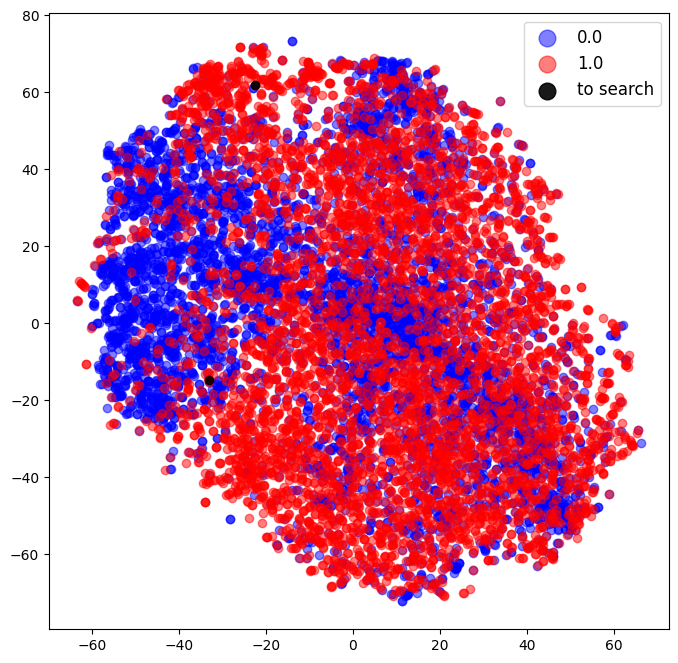

In [32]:
n_to_search = [2145, 8014]
def plot_embedding_2d(embeddings, repr_2d, labels = None, title=None, plot_x_val_2d_repr = True):
    if labels is None:
        labels = np.zeros(embeddings.shape[0])
    # Plot those points as a scatter plot and label them based on the pred labels
    colors = ['b', 'r', 'g', 'y', 'c', 'm', 'k', 'w']
    fig, ax = plt.subplots(figsize=(8,8))
    for lab in np.unique(labels):
        indices = labels==lab
        ax.scatter(repr_2d[indices,0], repr_2d[indices,1], c=colors[lab.astype(np.int32)], label = lab ,alpha=0.5)
    if plot_x_val_2d_repr:
        ax.scatter(repr_2d[:, 0][n_to_search], repr_2d[:, 1][n_to_search], c='k', label = 'to search' ,alpha=0.9)
    ax.legend(fontsize='large', markerscale=2)
    plt.show()
    
plot_embedding_2d(embeddings_all_both, repr_2d = repr_2d ,labels = y_labeled_both[:N_data], title="2D representation of the data")

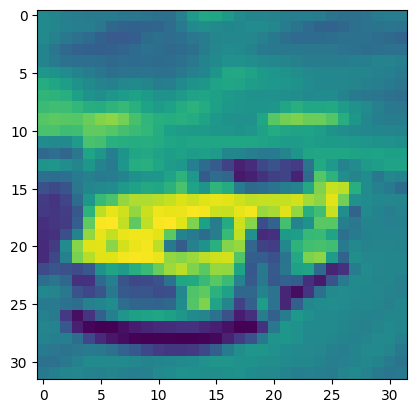

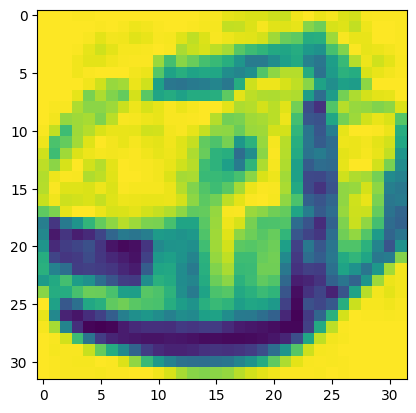

In [35]:
for n in [2145, 8014]:
    plt.imshow(X_all_both[n][0])
    plt.show()